Exercise 4
=========
### Team: The Coupled Oscillators
This exercise is focused on the influence of boundary conditions on the natural frequencies and modes, as well as on the estimation of transfer functions from time domain data.

You can re-use many things of previous ecercises ...

In [1]:
from scipy.io import mmread
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import inv

from scipy.signal import resample

import scipy.sparse

import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
matplot.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.figsize'] = [14, 10] # Resize plt stuff 
# Uncomment the following line and edit the path to ffmpeg if you want to write the video files!
#plt.rcParams['animation.ffmpeg_path'] ='N:\\Applications\\ffmpeg\\bin\\ffmpeg.exe'

from mpl_toolkits.mplot3d import Axes3D

import sys
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=20)

from numpy.fft import rfft, rfftfreq

from utility_functions import Newmark, nullspace

In [2]:
M = csc_matrix(mmread('Ms.mtx')) # mass matrix
K = csc_matrix(mmread('Ks.mtx')) # stiffness matrix
C = csc_matrix(K.shape) # a zeros damping matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes

N = X.shape[0] # number of nodes

nprec = 6 # precision for finding uniqe values

# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
x = np.unique(np.round(X[:,0],decimals=nprec))
y = np.unique(np.round(X[:,1],decimals=nprec))
z = np.unique(np.round(X[:,2],decimals=nprec))

# grid matrices
Xg = np.reshape(X[:,0],[len(y),len(x),len(z)])
Yg = np.reshape(X[:,1],[len(y),len(x),len(z)])
Zg = np.reshape(X[:,2],[len(y),len(x),len(z)])

tol = 1e-12

# constrain all edges
Nn = np.argwhere(np.abs(X[:,1]-X[:,1].max())<tol).ravel() # Node indices of N-Edge nodes
No = np.argwhere(np.abs(X[:,0]-X[:,0].max())<tol).ravel() # Node indices of O-Edge nodes
Ns = np.argwhere(np.abs(X[:,1]-X[:,1].min())<tol).ravel() # Node indices of S-Edge nodes
Nw = np.argwhere(np.abs(X[:,0]-X[:,0].min())<tol).ravel() # Node indices of W-Edge nodes

Nnosw = np.unique(np.concatenate((Nn,No,Ns,Nw))) #concatenate all and only take unique (remove the double ones)

# special points and the associated nodes
P1 = [0.2,0.12,0.003925]
N1 = np.argmin(np.sum((X-P1)**2,axis=1))
P2 = [0.0,-0.1,0.003925]
N2 = np.argmin(np.sum((X-P2)**2,axis=1))

# all node on the top of the plate
Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol).ravel()

# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nnosw],Iy[Nnosw],Iz[Nnosw]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

Influence of Boundary Conditions
------------------------------------------------
### Task 1: Soft Springs
Support the plate by flexible springs attached to the corners, and compare the resulting natural frequencies of the first ~10 modes with the ones of the theoretical "free" palte.
* Assume 4 springs at the corners in z-direction, consisting of rubber ($E$=0.1GPa) strings (diameter 2mm) and a length of 1m. How much will the springs elongate under gravity loading?
* How much do the natural frequencies change relative to the "free" plate? Do the modes change?
* How should you attach the plate (using strings of the given dimension) to have the least impact on natural frequencies and mode shapes?

> Hint: connecting a spring to ground corresponds to adding the spring constant to the diagonal element of the stiffness matrix.

In [3]:
#find corners
# special points and the associated nodes
P1 = [x.max(),y.max(),z.max()]
C1 = np.argmin(np.sum((X-P1)**2,axis=1))

P2 = [x.min(),y.max(),z.max()]
C2 = np.argmin(np.sum((X-P2)**2,axis=1))

P3 = [x.min(),y.min(),z.max()]
C3 = np.argmin(np.sum((X-P3)**2,axis=1))

P4 = [x.max(),y.min(),z.max()]
C4 = np.argmin(np.sum((X-P4)**2,axis=1))

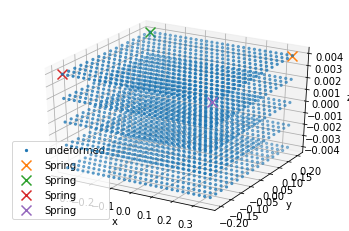

In [4]:
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

# Plot it in 3D
ax.scatter(X[:,0],X[:,1],X[:,2],s=5,label='undeformed') # undeformed

ax.scatter(X[C1,0],X[C1,1],X[C1,2],s=100,marker='x',label='Spring') # corner
ax.scatter(X[C2,0],X[C2,1],X[C2,2],s=100,marker='x',label='Spring') # corner
ax.scatter(X[C3,0],X[C3,1],X[C3,2],s=100,marker='x',label='Spring') # corner
ax.scatter(X[C4,0],X[C4,1],X[C4,2],s=100,marker='x',label='Spring') # corner

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
take = ax.legend(loc = 3)

A bar of length $l_0$ and cross-sectional area $A$ is subjected to a tensile or compressive load (force) along the $z$-axis and causes stress in the bar in the $z$-direction:

\begin{equation}
    \sigma_x  = \frac{F_z}{A}
\end{equation}

This results in an elongation $\varepsilon_z$ of the bar in $z$ direction:

\begin{equation}
    \varepsilon_z  = \frac{\Delta l }{l_0}
\end{equation}

The elongation of the bar depends on the force acting, in this case the stress in the bar. The proportionality constant $E$ represents the modulus of elasticity of the material of which the bar consists.

\begin{equation}
    \sigma_z = E \cdot \varepsilon_z
\end{equation}

By inserting the first two formulas and rearranging them, the following representation is obtained:

\begin{equation}
    F_z  = E \cdot A \cdot \frac{\Delta l}{l_0} \\
    F_z  = k_{spring} \cdot \Delta l
\end{equation}

Hooke's law can thus be applied where the acting force depends almost linearly on the deflection or extension, and is a generalization of Hooke's law for springs.

We can finally write the spring stiffness as

\begin{equation}
    k_{spring} = \frac{E \cdot A}{l_0}
\end{equation}


In [5]:
# Calculate the spring stiffness
E = 0.1*1e9 #N/m^2
d = 2.0*1e-3 #m
l0 = 1.0 #m
A = d**2*np.pi/4 #m^2
k_spring = E*A/l0 #N/m

# calculate static deformation
g = 9.81 #m/s^2
m_ges = np.sum(M[Iz,Iz]) #kg
F_ges = m_ges*g #N
k_spring_ges = 4*k_spring
dL = F_ges/k_spring_ges
print('The springs elongate under gravity: ' + str(dL) + ' m')
print('The springs elongate under gravity: ' + str(dL*1e3) + ' mm')

The springs elongate under gravity: 0.005999223773265883 m
The springs elongate under gravity: 5.999223773265883 mm


#### First we calculate the frequencies without the springs attached

In [6]:
# only compute a subset of modes of the reduced model
k = 10
W,V = eigsh(K,k,M,sigma=0,which='LM',maxiter = 1000)

#### Now calculate everything with springs attached

In [7]:
# Build a new K-Matrix
Ks = K[:,:]

# Add springs to the corners
Ks[Iz[C1],Iz[C1]] += k_spring
Ks[Iz[C2],Iz[C2]] += k_spring
Ks[Iz[C3],Iz[C3]] += k_spring
Ks[Iz[C4],Iz[C4]] += k_spring

In [8]:
Ws,Vs = eigsh(Ks,k,M,sigma=0,which='LM',maxiter = 1000)

In [9]:
def plotmodes(V_var,W_var) :
    for i,v in enumerate(V_var.T) : # iterate over eigenvectors
        c = np.reshape(v[Iz[Nt]],[len(y),len(x)])
        lim = np.max(np.abs(c))
        fig,ax = plt.subplots(nrows=1, ncols=1,figsize=[3.5,2])
        ax.contourf(x,y,c,cmap=plt.get_cmap('RdBu'),vmin=-lim,vmax=lim)
        ax.set_aspect('equal')
        ax.set_title('Mode %i @ %f Hz'%(i+1,np.sqrt(abs(W_var[i]))/2/np.pi))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.tight_layout()

#### Plot the modes of the original system (theoretical "free" plate)

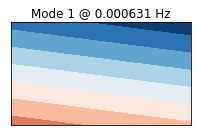

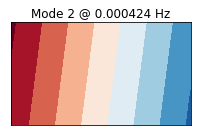

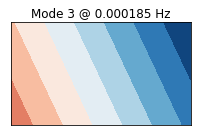

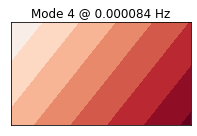

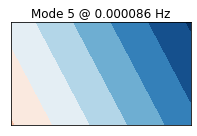

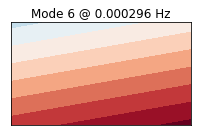

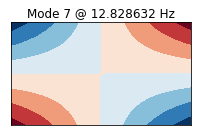

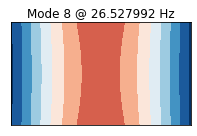

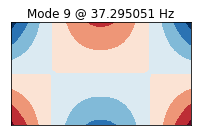

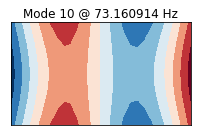

In [10]:
# Plot Modes
plotmodes(V,W)

#### Plot the modes of the spring attached system

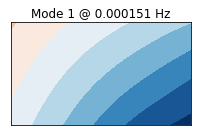

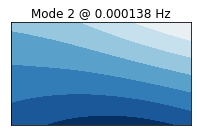

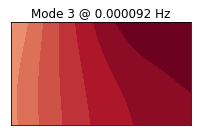

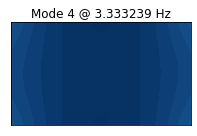

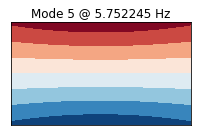

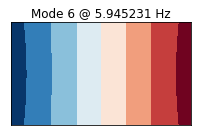

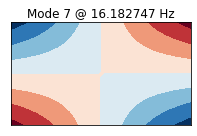

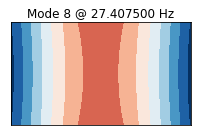

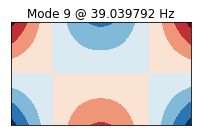

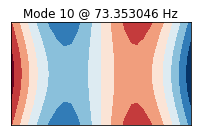

In [11]:
# Plot modes
plotmodes(Vs,Ws)

#### How would you attach the springs to reduce the influence of the springs?

By looking at the eigenvalues it's obvious that the rotational modes (4-6) are most influenced by the current arrangement. It could be wise to do more than one test and always change the spring position. To mitigate the influence of the springs a different arrangement can be done: Two spring uppwards, one downwards. This would help for rotation. See example below.

In [12]:
k_spring = k_spring/np.sqrt(3)

# Build a new K-Matrix
Ks_alt = K[:,:]

# Add springs to the corners
# Ks_alt[Ix[C1],Ix[C1]] += k_spring
# Ks_alt[Iy[C1],Iy[C1]] += k_spring
Ks_alt[Iz[C1],Iz[C1]] += k_spring

# Ks_alt[Ix[C2],Ix[C2]] += k_spring
# Ks_alt[Iy[C2],Iy[C2]] += k_spring
Ks_alt[Iz[C2],Iz[C2]] += k_spring

# Ks_alt[Ix[C3],Ix[C3]] += k_spring
# Ks_alt[Iy[C3],Iy[C3]] += k_spring
Ks_alt[Iz[C3],Iz[C3]] -= k_spring

# Ks_alt[Ix[C4],Ix[C4]] += k_spring
# Ks_alt[Iy[C4],Iy[C4]] += k_spring
Ks_alt[Iz[C4],Iz[C4]] -= k_spring

In [13]:
Ws_alt,Vs_alt = eigsh(Ks_alt,k,M,sigma=0,which='LM',maxiter = 1000)

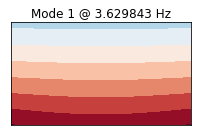

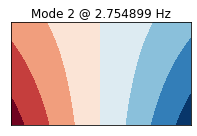

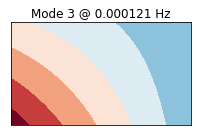

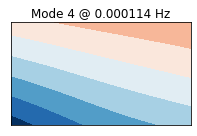

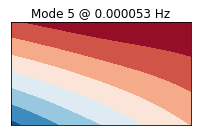

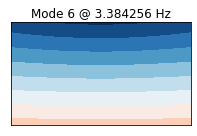

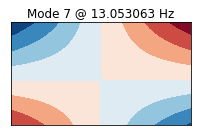

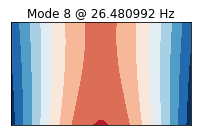

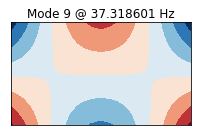

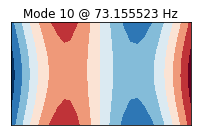

In [14]:
plotmodes(Vs_alt,Ws_alt)

### Clamped Plate
The plate is clamped at all edges. 
To clamp a real plate at the outer dimensions of our model plate, we fabricate it larger by a distance $d_s = 1.5 t_s$, where $t_s$ is the thickness of the plate, and clamp it between two stiff flanges.

To estimate the stiffness of this clamped support, we use a very simplified model: Assume the flanges are rigid, but we use a layer of rubber with thickness $h_s$=1mm between them. 
The vertical bedding stiffness (stress per displacement) of this support can easily be computed: $k_z = 2 E_s/h_s$
To compute the equivalent springs stiffness to apply to the nodes, multiply the bedding stiffness by appropriate "nodal areas".
To model the response of the support with respect to rotations of the plate, apply a bedding stiffness in normal direction of the vertical plate edges (i.e. springs acting in x- or y-directions).
The bedding stiffness in this case can be estimated by requiring that a small rotation delivers the same bending moment for both cases: one obtains $k_x=k_y=8(t_s/d_s)^3k_z$.

Compare the theoretical clamped model (as in the previous examples), with the more realistic "flexible" clamping described above.
* what are the difference in natural frequencies?
* plot the mode shapes? Do they differ?

In [15]:
# Calculate distance
ts = z.max() - z.min() #in m
b = y.max() - y.min() #in m
h = x.max() - x.min() #in m

dX = h/(len(x)-1) #Grid spacing
dY = b/(len(y)-1) #Grid spacing
dZ = ts/(len(z)-1) #Grid spacing

ds = 1.5*ts #plate larger by ds in m

First the node-area is evaluated and the overall stiffness will be partially distrubed to all nodes

In [16]:
# rubber flanges
hs = 1*1e-3 #m

# Stiffness
kz_a = 2*E/hs #N/m
kxy_a = 8*(ts/ds)**3*kz_a #N/m

In [17]:
# calculate equivalent springs stiffness
# Ao = b*h #in m^2
# At = (b+2*ds)*(h+2*ds) #in m^2
# Ad = At - Ao #in m^2

# dAx = dY*dZ  #nodal area
# dAy = dX*dZ  #nodal area
# dAz = dY*dX  #nodal area

# kxy = kxy*dAz/Ad
# kz = kz*dAz/Ad

The stiffness is added to the upper and lower layer border nodes

In [18]:
N1 = np.argwhere((np.abs(X[:,1]-X[:,1].max()) + np.abs(X[:,2]-X[:,2].max())) < tol).ravel()
N2 = np.argwhere((np.abs(X[:,1]-X[:,1].max()) + np.abs(X[:,2]-X[:,2].min())) < tol).ravel()

N3 = np.argwhere((np.abs(X[:,0]-X[:,0].max()) + np.abs(X[:,2]-X[:,2].max())) < tol).ravel()
N4 = np.argwhere((np.abs(X[:,0]-X[:,0].max()) + np.abs(X[:,2]-X[:,2].min())) < tol).ravel()

N5 = np.argwhere((np.abs(X[:,1]-X[:,1].min()) + np.abs(X[:,2]-X[:,2].max())) < tol).ravel()
N6 = np.argwhere((np.abs(X[:,1]-X[:,1].min()) + np.abs(X[:,2]-X[:,2].min())) < tol).ravel()

N7 = np.argwhere((np.abs(X[:,0]-X[:,0].min()) + np.abs(X[:,2]-X[:,2].max())) < tol).ravel()
N8 = np.argwhere((np.abs(X[:,0]-X[:,0].min()) + np.abs(X[:,2]-X[:,2].min())) < tol).ravel()

Nb = np.unique(np.concatenate((N1,N2,N3,N4,N5,N6,N7,N8)))

In [19]:
kz_t = kz_a/len(Nnosw)
kxy_t = kxy_a/len(Nnosw)

kz = kz_a/len(Nb)
kxy = kxy_a/len(Nb)

In [20]:
# Build a new K-Matrix
Kc2 = K[:,:]
Kc_t = K[:,:]

for i,node in enumerate(Nb) :
    # Add springs to the corners
    Kc2[node*3,node*3] += kxy
    Kc2[node*3+1,node*3+1] += kxy
    Kc2[node*3+2,node*3+2] += kz
    
for i,node in enumerate(Nnosw) :
    # Add springs to the corners
    Kc_t[node*3,node*3] += kxy_t
    Kc_t[node*3+1,node*3+1] += kxy_t
    Kc_t[node*3+2,node*3+2] += kz_t

In [21]:
# compute the reduced system
Kc = csc_matrix(K[np.ix_(~Ic,~Ic)])
Mc = csc_matrix(M[np.ix_(~Ic,~Ic)])
Cc = csc_matrix(C[np.ix_(~Ic,~Ic)])

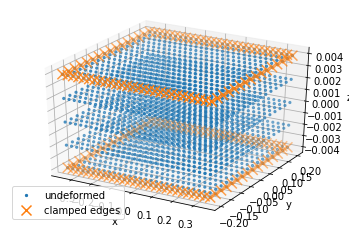

In [22]:
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

# Plot it in 3D
ax.scatter(X[:,0],X[:,1],X[:,2],s=5,label='undeformed') # undeformed

ax.scatter(X[Nb,0],X[Nb,1],X[Nb,2],s=100,marker='x',label='clamped edges') # corner

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
take = ax.legend(loc = 3)

In [23]:
# only compute a subset of modes of the reduced model
k = 10
Wc2,Vc2 = eigsh(Kc2,k,M,sigma=0,which='LM',maxiter = 1000)

In [24]:
# only compute a subset of modes of the reduced model
k = 10
Wc,Vc = eigsh(Kc,k,Mc,sigma=0,which='LM',maxiter = 1000)

Vc_full = np.zeros_like(Vc2)
Vc_full[~Ic] = Vc

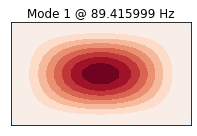

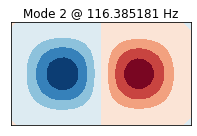

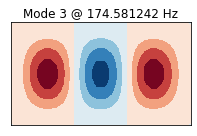

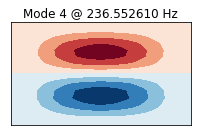

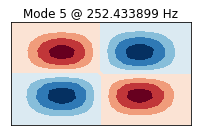

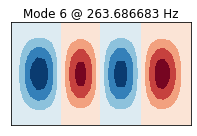

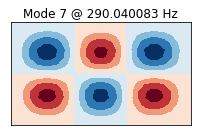

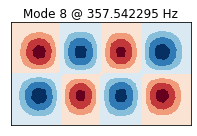

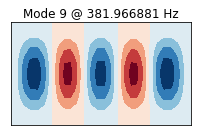

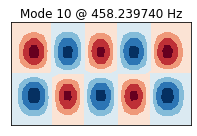

In [25]:
# Plot modes
plotmodes(Vc2,Wc2)

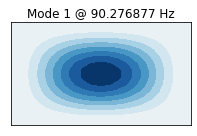

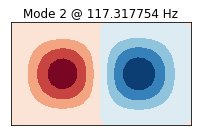

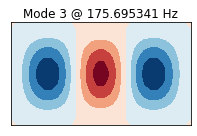

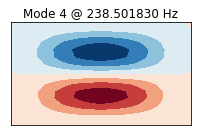

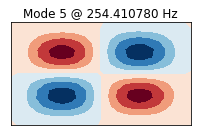

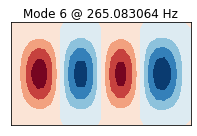

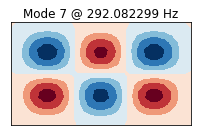

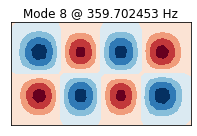

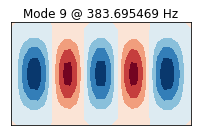

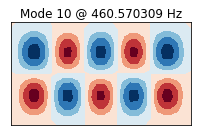

In [26]:
# Plot modes
plotmodes(Vc_full,Wc)

In [27]:
# Calc the delta of the eigenvalues
deltaW = np.sqrt(abs(Wc))/2/np.pi - np.sqrt(abs(Wc2))/2/np.pi
print('dW = %a' % deltaW )

dW = array([0.8608781 , 0.93257311, 1.11409934, 1.94921981, 1.97688059,
       1.396381  , 2.04221617, 2.1601575 , 1.72858742, 2.3305693 ])


Difference in Modeshapes is minor (colors are switched, needs further investigation --> could be that hills and valleys are also switched). Difference in Eigenfrequency is also not great.

Let's check another way on how to "apply" the springs on the system. All edges, not only top and bottom.

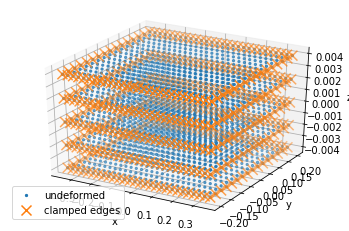

In [71]:
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

# Plot it in 3D
ax.scatter(X[:,0],X[:,1],X[:,2],s=5,label='undeformed') # undeformed

ax.scatter(X[Nnosw,0],X[Nnosw,1],X[Nnosw,2],s=100,marker='x',label='clamped edges') # corner

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
take = ax.legend(loc = 3)

In [29]:
# only compute a subset of modes of the reduced model
k = 10
Wc_t,Vc_t = eigsh(Kc_t,k,M,sigma=0,which='LM',maxiter = 1000)

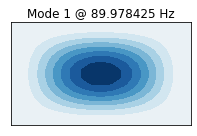

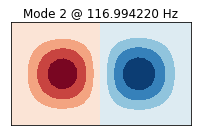

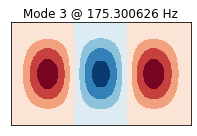

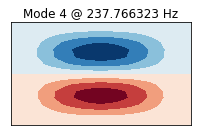

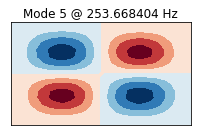

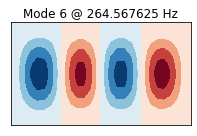

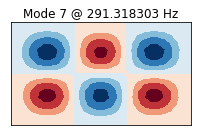

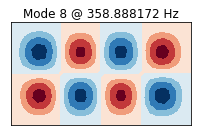

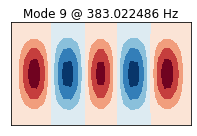

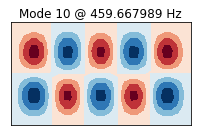

In [30]:
# Plot modes
plotmodes(Vc_t,Wc_t)

Shaker and Interactions
----------------------------------

### Shaker Model

Assume a shaker model with table (mass $m_t$=2kg) and body (mass $m_b$=10kg) connedcted by spring and dashpot ($k_t$=20kN/m and $c_t$=20Ns/m, respectively). 
The body is flexibly connected to the ground with support stiffness $k_b$=160MN/m and damping constant $c_b$=400Ns/m.
The coil has an ohmic resistance $R$=0.5Ohm and inductance $L$=100$\mu$H.
Electromagnetic force and induced voltage (electromotive force) are related to the current and relative velocity, respecively, by $B_l$=50Tm.

* Plot the transfer function of the coil current with respect to voltage excitation
* Plot the transfer functions of the displacment dofs with respect to voltage excitation

### Answer:
We model the shaker by an ODE system of the form 
$$
\boldsymbol{M}\ddot{\boldsymbol{x}}+\boldsymbol{c}\dot{\boldsymbol{x}}+\boldsymbol{K}\boldsymbol{x} = \boldsymbol{f(t)}
$$
Note: The model is depicted in the lecture slides on p.22(116) of lecture 4.
The system's equations can be derived via balance laws for the mechanical (Newton's law) and electrical (Kirchoff's voltage law (KVL)) systems. For the coupling equations we have: 
First, the magnetic force 
$$
F_m=B_l i(t),
$$
which couples the electrical to the mechanical system. 
Second, the change in relative displacement from the mechanical system induces a voltage 
$$
V_e(t) = B_l (\dot{x_t}-\dot{x_b})
$$
on the electrical system. We choose $ \boldsymbol{x}=[x_t\quad x_b\quad V_e]^T $ and recast the equations into matrix form

$$
\begin{bmatrix}
m_t & 0 & 0\\
0 & m_b & 0 \\
0 & 0 & 0 \\
\end{bmatrix}
\ddot{\boldsymbol{x}}
+
\begin{bmatrix}
c_t & -c_t & 0\\
-c_t & c_t+c_b & 0 \\
B_l & -B_l & L \\
\end{bmatrix}
\dot{\boldsymbol{x}}
+
\begin{bmatrix}
k_t & -k_t & -B_l\\
-k_t & k_t+k_b & B_l \\
0 & 0 & R \\
\end{bmatrix}
\boldsymbol{x}
=
\begin{bmatrix}
0\\
0\\
V(t)\\
\end{bmatrix}.
$$

In [31]:
# Mechanical parameters
m_t = 2 # [kg] mass table
m_b = 10 # [kg] mass body
k_t = 20E3 # [N/m] spring top
c_t = 20E3 # [Ns/m] dashpot top
k_b = 160E6 # [N/m] spring support
c_b = 400 # [Ns/m] dashpot support

# Electrical parameters
R = 0.5 # [Ohm] coil resistance
L = 100E-6 # [T] coil inductance
B_l = 50 # [Tm] magnetic flux density * length of coil

# Assign system matrices M, C and K
M_shaker = np.diag([m_t, m_b, 0])
C_shaker = np.array([
        [c_t, -c_t, 0],
        [-c_t, c_t + c_b, 0],
        [B_l, -B_l, L]
])

K_shaker = np.array([
        [k_t, -k_t, -B_l],
        [-k_t, k_t + k_b, B_l],
        [0, 0, R]
])

### How to obtain the TFs 
If we convert our system to the frequency domain we have
$$ (-\omega^2\mathbf{M}+j\omega\mathbf{C}+\mathbf{K})\hat{\mathbf{x}}(\omega)=\mathbf{Z}(\omega)\hat{\mathbf{x}}(\omega)=\hat{\mathbf{f}}(\omega), $$
where $\mathbf{Z}(\omega)$ is the impedance matrix. The inverse of the impedance matrix $\mathbf{Z}^{-1}(\omega) = \mathbf{H}(\omega) $ contains the transfer functions $H_{ij}(\omega)$ between the i-th DoF and the j-th forcing vector entry.

In [32]:
f = np.linspace(0, 1E3, 500) # [Hz] frequency array 
angular_frequencies = 2*np.pi*f # [rad/s] angular freq. array

H_shaker = np.zeros((
    M_shaker.shape[0],
    M_shaker.shape[1],
    angular_frequencies.shape[0]),
    dtype=complex
)

count = 0
for w in angular_frequencies:
    Z_shaker = -w**2*M_shaker + 1j*w*C_shaker + K_shaker 
    H_shaker[:, :, count] = np.linalg.inv(Z_shaker)
    count += 1

tf_voltage_xtop = H_shaker[0, 2, :]
tf_voltage_xbot = H_shaker[1, 2, :]
tf_voltage_current = H_shaker[2, 2, :]


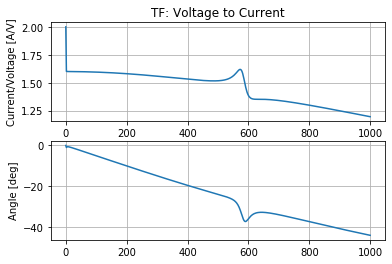

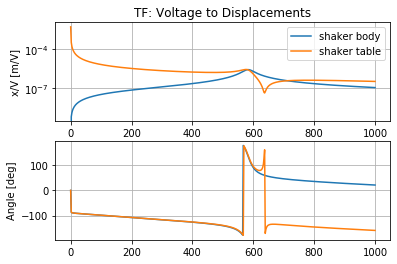

In [33]:
# TF Voltage/Current Plot 
plt.figure()
plt.subplot(211)
plt.ylabel('Current/Voltage [A/V]')
plt.xlabel('Frequency [Hz]')
plt.title('TF: Voltage to Current')
plt.plot(f, np.abs(tf_voltage_current))
plt.grid(True)
plt.subplot(212)
plt.ylabel('Angle [deg]')
take = plt.plot(f, np.angle(tf_voltage_current, deg=True))
plt.grid(True)
plt.show()

# TF Voltage/Displacements Plot
plt.figure()
plt.subplot(211)
plt.semilogy(f, np.abs(tf_voltage_xbot))
plt.semilogy(f, np.abs(tf_voltage_xtop))
plt.ylabel('x/V [m/V]')
plt.xlabel('Frequency [Hz]')
plt.title('TF: Voltage to Displacements')
plt.legend(['shaker body', 'shaker table'])
plt.grid(True)
plt.subplot(212)
plt.ylabel('Angle [deg]')
take = plt.plot(f, np.angle(tf_voltage_xbot, deg=True))
take = plt.plot(f, np.angle(tf_voltage_xtop, deg=True))
plt.grid(True)
plt.show()

### Interactions between Shaker and Plate

Couple the plate and shaker model using a flexible steel stinger (rod) with a length $l_r$=100mm and diameter $d_r$=4mm. The rod should connect to the plate at $P_1$=(0.2,0.12,0.003925)m, and excite the plate in z-direction.

* Compute the coupled natural frequencies of the system.
* Plot the mode shapes.

Tipps:
* Combine the plate system matrix and the shaker model in a single matrix
* The rod/stinger can be included in the shaler model by adding a displacement dof for the end (the start corresponds to the table displacement). The mass off the stinger can be lumped (distributed) to the two dofs.
* You can combine spare matrices by using `scipy.sparse.hstack()` and `scipy.sparse.vstack()`
* Use the nullspace to connect the dof of the of the rod to the dof on the plate

In [34]:
# Attach at
P1 = [0.2,0.12,0.003925]

# input parameters
l_rod = 0.1 # [m] length rod
d_rod = 4E-3 # [m] diameter rod
E = 210E9 # [Pa] Young's modulus steel
density = 7850 # [kg/m^3] Density of generic steel

# Steel stinger
A_rod = d_rod**2*np.pi/4 # Cross sectional area
k_rod = E*A_rod/l_rod # Stiffness constant
m_rod = density*A_rod*l_rod # Mass


### Couple the two systems:

In [35]:
# Add steel stinger/rod to shaker system (sr = shaker+rod)

M_shaker_added_mass = M_shaker
M_shaker_added_mass[0,0] = M_shaker[0,0] + m_rod/2 # Add m_rod/2 from rod to top of shaker

M_sr = np.block([ 
    [m_rod/2, np.zeros((1,3))],
    [np.zeros((3,1)), M_shaker]
])

C_sr = np.block([
    [np.zeros((1,4))],
    [np.zeros((3,1)), C_shaker]
])

K_sr = np.array([ # NOTE: Think about a more elegant way to do this since there exists a block matrix pattern!
    [k_rod, -k_rod, 0, 0],
    [-k_rod, k_rod + k_t, -k_t, -B_l],
    [0,-k_t, k_t + k_b, B_l],
    [0, 0, 0, R]
])

# Combine system matrices
M_plateshaker_uncoupled = scipy.sparse.block_diag((M, M_sr))
C_plateshaker_uncoupled = scipy.sparse.block_diag((C, C_sr))
K_plateshaker_uncoupled = scipy.sparse.block_diag((Kc2, K_sr))

# Couple rod and plate at P1

N1 = np.argmin(np.sum((X-P1)**2,axis=1)) # Select node
DOF_rod = M_plateshaker_uncoupled.shape[0] - 4 # Select DOF of rod
B_rod_plate = np.zeros((1, M_plateshaker_uncoupled.shape[0])).T # Build constraint matrix
B_rod_plate[Iz[N1]] = 1 # DOF Iz[N1] = DOF rod constraint
B_rod_plate[DOF_rod] = -1
B_rod_plate = B_rod_plate.T

Q_rod_plate = csc_matrix(nullspace(B_rod_plate)) # Get nullspace for constraint matrix B_rod_plate
M_plateshaker = Q_rod_plate.T @ M_plateshaker_uncoupled @ Q_rod_plate # Constrain by similarity transformation
C_plateshaker = Q_rod_plate.T @ C_plateshaker_uncoupled @ Q_rod_plate
K_plateshaker = Q_rod_plate.T @ K_plateshaker_uncoupled @ Q_rod_plate




Data Display and FRF Estimation
-----------------------------------------------

### Task 2: Chrip Signal
Define a Chirp signal to cover the first 10 modes of the (realistically) clamped plate. Use a signal length of 0.5s.
* Plot time signal and frequency spectrum of the signal.

In [36]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax

import time

In [37]:
## only compute a subset of modes of the reduced model
k = 10
W,V = eigsh(Kc2,k,M,sigma=0,which='LM',maxiter = 1000)
print(np.sqrt(W)/2/np.pi)

[ 89.41599888 116.38518117 174.58124192 236.5526098  252.43389919
 263.68668308 290.04008282 357.54229526 381.96688116 458.23973971]


In [38]:
## Chirp signal t cover the first 10 modes with signal lenght of 0,5s
sig_lenght = 0.5 #signal lenght
f_min = round((np.sqrt(W[0])/2/np.pi)-50) #first mode in Hz -50Hz to cover all
f_max = round((np.sqrt(W[9])/2/np.pi)+50) #tenth mode in Hz +50Hz to cover all
steps = 2**13
dt = sig_lenght/steps
f_sample = 1/dt
t = np.linspace(0, sig_lenght, steps)
y_t = np.sin(2*np.pi*t*(f_min + (f_max - f_min) * (t/sig_lenght))) #Chrip in time domain

f = rfftfreq(t.size, dt)
frequencies_measurement = f
y_f = rfft(y_t)
y_f_abs = np.abs(y_f)

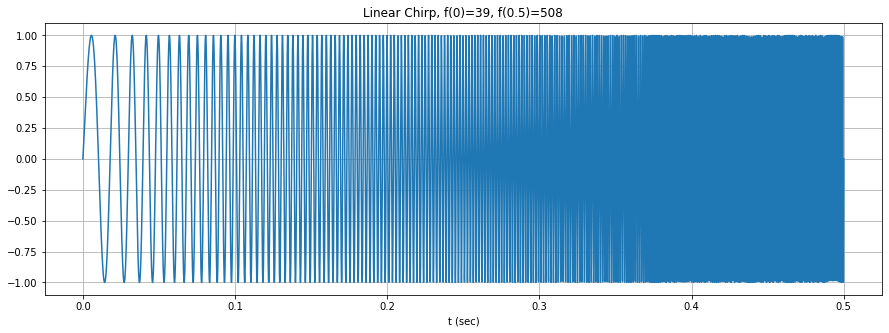

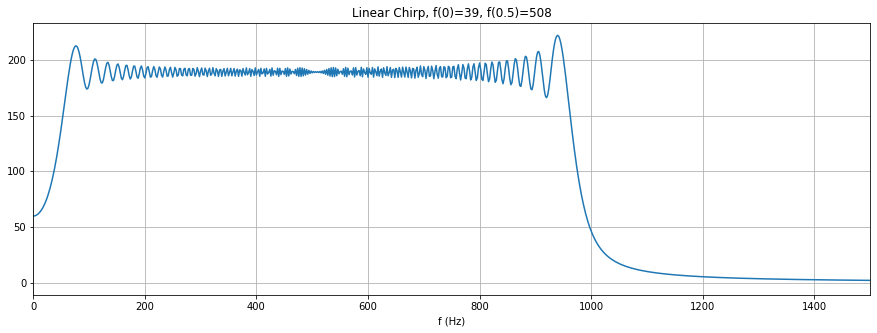

In [39]:
## Plot of time signal 
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, y_t)
plt.title("Linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.grid()
plt.show()

## Plot of the frequency spectrum
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(f, y_f_abs)
plt.title("Linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('f (Hz)')
plt.xlim(0, 1500)
plt.grid()
plt.show()

* What start and end frequency did you choose?

In [40]:
print(f_min)
print(f_max)

39.0
508.0


### Shaker Experiment
Use the coupled shaker and plate model, and excite the shaker with the Chirp signals as voltage input.
Compute the transient response. 
Assume Rayleigh damping with $\alpha=2.15$ and $\beta=3e-5$ for the plate.

In [41]:
#assemble Damping-Matrix for the reduced sys and given aplha and beta for Rayleigh damping
alpha = 2.15
beta = 0.00003
C = alpha * M + beta * Kc2
C_plateshaker_uncoupled = scipy.sparse.block_diag((C, C_sr))
C_plateshaker = Q_rod_plate.T @ C_plateshaker_uncoupled @ Q_rod_plate

In [42]:
# assemble forcing vector
force = np.array(np.zeros((3*N+4, y_t.shape[0]))) # Initialize load vector array; Note that the columns contain the force values from 0 to T!
force[-1,:] = y_t # chirp signal as voltage input
f_plateshaker = Q_rod_plate.T @ force

In [43]:
start_time = time.time()

# Time integration with Newmark-Method
u0 = np.zeros(3*N+3) # Initial displacement set to 0.
u_Q, v_Q, a_Q = Newmark(M_plateshaker, C_plateshaker, K_plateshaker, f_plateshaker, t, u0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 140.86759614944458 seconds ---


In [44]:
# Transformation into the original system
u = Q_rod_plate @ u_Q
v = Q_rod_plate @ v_Q
a = Q_rod_plate @ a_Q

# gather displacement of tabel x_t, displacement of membran x_b and coil current
x_t = u[-3,:]
x_t_dot = v[-3,:]
x_t_ddot = a[-3,:]
x_b = u[-2,:]
x_b_dot = v[-2,:]
x_b_ddot = a[-2,:]
current = u[-1,:]

* Plot the time signal of the coil current

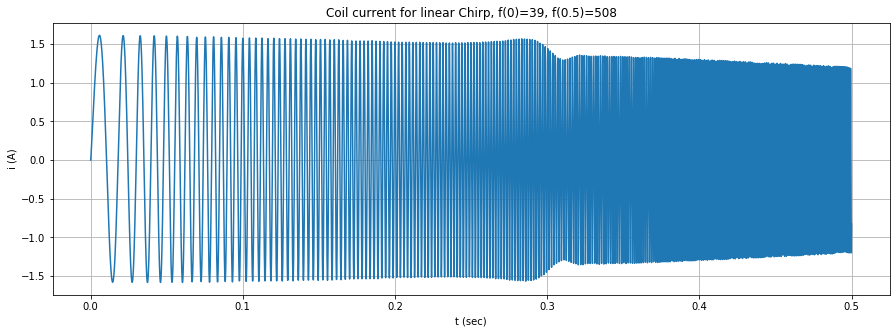

In [45]:
# plot time signal of the coil current
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, current)
plt.title("Coil current for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.ylabel('i (A)')
plt.grid()
plt.show()

* Plot the time signal of the center point displacement (in z direction) of the plate

In [46]:
#find node number in the center
PC = [0.,0.,0.]
NC = np.argmin(np.sum((X-PC)**2,axis=1))
PC_disp_z = u[Iz[NC],:]

# PC_disp_z_f = rfft(PC_disp_z)
# PC_disp_z_f_abs = np.abs(PC_disp_z_f)

In [47]:
PC_disp_z.shape

(8192,)

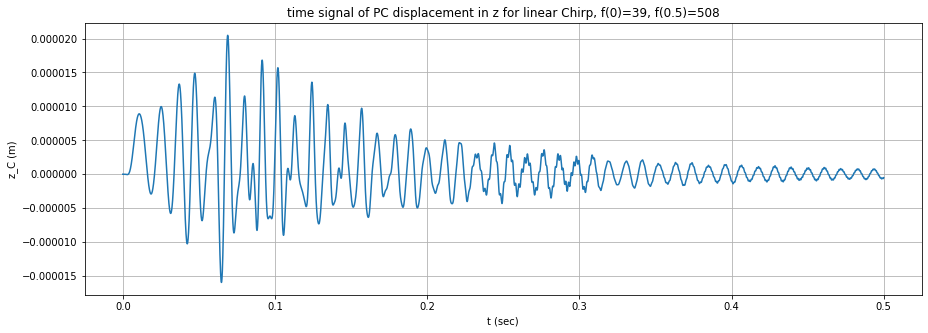

In [48]:
# plot time signal of PC displacement in z for linear Chirp
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, PC_disp_z)
plt.title("time signal of PC displacement in z for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.ylabel('z_C (m)')
plt.grid()
plt.show()

# # plot frequence spec of PC displacement in z for linear Chirp
# fig, ax = plt.subplots(figsize=(15,5))
# plt.plot(f, PC_disp_z_f_abs)
# plt.title("frequence spec of PC displacement in z for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
# plt.xlabel('f (sec)')
# plt.grid()
# plt.show()

* Compute the time signal of the force in the stinger exciting the plate, and plot it.

In [49]:
# displacemet of point where shaker is connected
P1_disp_z = u[Iz[N1],:]
F_stinger = k_rod * (P1_disp_z - x_t)

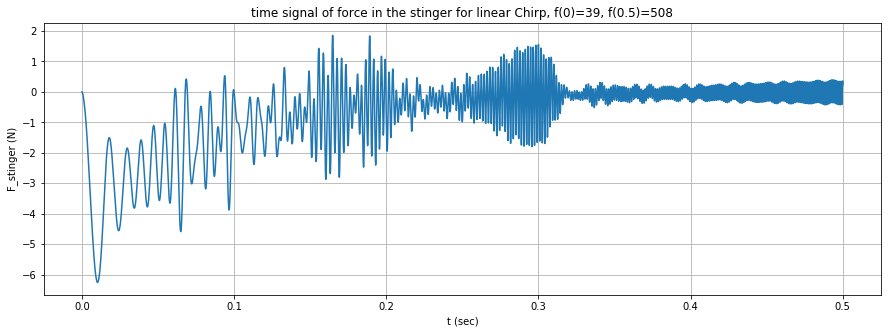

In [50]:
# plot time signal of the force in the stinger exciting the plate
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, F_stinger)
plt.title("time signal of force in the stinger for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.ylabel('F_stinger (N)')
plt.grid()
plt.show()

another method:
From equation of motion
$$
m_t \ddot{x_t} + c_t (\dot{x_t} -\dot{x_b}) + k_t (x_t - x_b) - f_m = F_{stinger}
$$
$$
f_m =  B_l i
$$

In [51]:
# Compute force of stinger from principe of linear momentum
F_stinger_2 = m_t * x_t_ddot + c_t * (x_t_dot - x_b_dot) + k_t * (x_t - x_b) - B_l * current

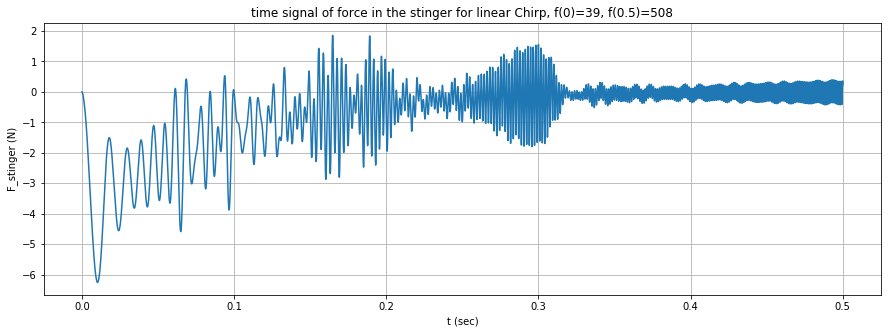

In [52]:
# plot time signal of the force in the stinger exciting the plate
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(t, F_stinger_2)
plt.title("time signal of force in the stinger for linear Chirp, f(0)="+str(int(round((np.sqrt(W[0])/2/np.pi)-50)))+", f("+str(sig_lenght)+")="+str(int(round((np.sqrt(W[9])/2/np.pi)+50))))
plt.xlabel('t (sec)')
plt.ylabel('F_stinger (N)')
plt.grid()
plt.show()

### FRF Estimation

Use the FFT compute the frequency spectrum of the response.
Estimate transfer functions between system parameters by dividing the respective frequency spectra, e.g. output displacement divided by input voltage.
In order to estimate the transfer function of the plate with respect to a vertical force, you need to compute the ratio of two output quantities of the model.

Compute the harmonic response of the system as a reference solution for the transfer functions estimated from time domain data.

Tipp: Only compute the harmonic solution in a suitable frequency range! For easier computation of differences use a common frequency resolution.

In [53]:
from scipy.sparse.linalg import spsolve

In [54]:
f_idx_upper = int(np.where(f == f[f <= f_max][-1])[0])
f_idx_lower = int(np.where(f == f[f >= f_min][0])[0])
new_window = f[f_idx_lower:f_idx_upper]

Nr_steps = len(new_window)

* Estimate the transfer function between input voltage and vertical center point displacement of the plate.
* Plot the estimated FRF and the reference solution from a hamonic analysis to compare them.

In [55]:
start_time = time.time()

frequencies = np.linspace(f_min,f_max,Nr_steps)

response = np.zeros((
    M_plateshaker.shape[1],
    frequencies.shape[0]),
    dtype=complex
)

# Assemble one (or several) forcing vectors
force = np.zeros(3*N+4)
force[-1] = 1.0 # voltage signal
f_plateshaker = Q_rod_plate.T @ force

for i,f in enumerate(frequencies):
    omega = 2*np.pi*f
    Z = K_plateshaker + complex(0,1) * omega * C_plateshaker - omega**2 * M_plateshaker 
    response[:,i] = spsolve(Z,f_plateshaker)
    
harmonic_voltage = Q_rod_plate @ response
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 718.620297908783 seconds ---


In [56]:
estimated_tf_voltage_PC = rfft(PC_disp_z)/rfft(y_t) # One sided spectrum of tf for bode-like plots 
estimated_tf_voltage_PC_2_sided = np.fft.fft(PC_disp_z)/np.fft.fft(y_t) # Two sided spectrum for nyquist-like plots 

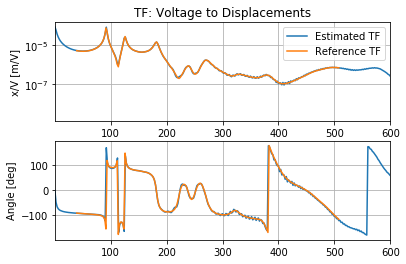

In [57]:
# TF Voltage/Displacements Plot
plt.figure()

plt.subplot(211)
plt.semilogy(frequencies_measurement, np.abs(estimated_tf_voltage_PC), label='Estimated TF')
plt.semilogy(frequencies, np.abs(harmonic_voltage[Iz[NC],:]), label='Reference TF')
plt.ylabel('x/V [m/V]')
plt.xlabel('Frequency [Hz]')
plt.xlim(1,600)
plt.title('TF: Voltage to Displacements')
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.ylabel('Angle [deg]')
take = plt.plot(frequencies_measurement, np.angle(estimated_tf_voltage_PC, deg=True))
take = plt.plot(frequencies, np.angle(harmonic_voltage[Iz[NC], :], deg=True))
plt.xlim(1,600)
plt.grid(True)
plt.show()


* Estimate the FRF from plate force to center displacement from the coupled shaker model.


In [58]:
estimated_tf_force_PC = rfft(PC_disp_z)/rfft(F_stinger) 
estimated_tf_force_PC_2_sided = np.fft.fft(PC_disp_z)/np.fft.fft(F_stinger)

* Plot the estimate from the time domain to the harmonic reference solution. Compute the $\Delta$FRF to compare.

Just transform the harmonic solution with magic:

In [59]:
x_t_new = harmonic_voltage[-3,:] #m/V
P1_disp_z_new = harmonic_voltage[Iz[N1],:] #m/V
F_stinger_new = k_rod * (P1_disp_z_new - x_t_new) #F/V

x_Nc = harmonic_voltage[Iz[NC],:] #m/V
x_v = harmonic_voltage[-1,:] #V/V

harmonic_force_v2 = x_Nc/F_stinger_new

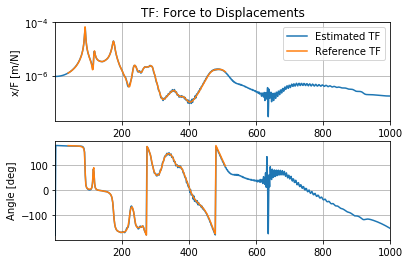

In [60]:
# TF Force/Displacements Plot
plt.figure()

plt.subplot(211)
plt.semilogy(frequencies_measurement, np.abs(estimated_tf_force_PC), label='Estimated TF')
plt.semilogy(frequencies, np.abs(harmonic_force_v2), label='Reference TF')
plt.ylabel('x/F [m/N]')
plt.xlabel('Frequency [Hz]')
plt.xlim(1,1000)
plt.title('TF: Force to Displacements')
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.ylabel('Angle [deg]')
take = plt.plot(frequencies_measurement, np.angle(estimated_tf_force_PC, deg=True))
take = plt.plot(frequencies, np.angle(harmonic_force_v2, deg=True))
plt.xlim(1,1000)
plt.grid(True)
plt.show()

For the difference of the TFs we only compare where data is given. Previously the upper and lower bound of the frequenccies were calculated which comes now handy:

In [61]:
delta_frf_PC = estimated_tf_force_PC[f_idx_lower:f_idx_upper] - harmonic_force_v2

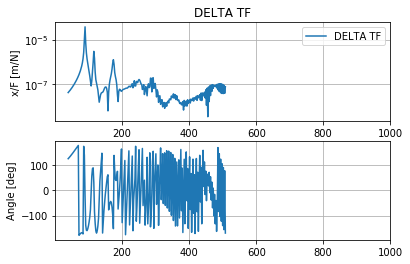

In [62]:
# DELTA TF PLOT
plt.figure()
plt.subplot(211)
plt.semilogy(frequencies, np.abs(delta_frf_PC), label='DELTA TF')

plt.ylabel('x/F [m/N]')
plt.xlabel('Frequency [Hz]')
plt.xlim(1,1000)
plt.title('DELTA TF')
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.ylabel('Angle [deg]')
take = plt.plot(frequencies, np.angle(delta_frf_PC, deg=True))
plt.xlim(1,1000)
plt.grid(True)
plt.show()

* Compare the FRF from plate force to center displacement obtained from the coupled plate-shaker model to one obtained from an equivalent plate directly subjected to an external force (only plate model without shaker).

In [63]:
force = np.array(np.zeros((3*N, y_t.shape[0])))
force[Iz[N1],:] = y_t # chirp signal as force input on N1

In [64]:
start_time = time.time()

# Time integration with Newmark-Method
u0 = np.zeros(3*N) # Initial displacement set to 0.
u, v, a = Newmark(M, C, Kc2, force, t, u0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 138.96530866622925 seconds ---


In [65]:
PC_disp_z = u[Iz[NC],:]
estimated_tf_force_PC_plate = rfft(PC_disp_z)/rfft(y_t)
estimated_tf_force_PC_plate_2_sided = np.fft.fft(PC_disp_z)/np.fft.fft(y_t)

* Plot the FRF from plate force to center displacement from coupled plate-sahker model and pure plate model. Compute the $\Delta$FRF to compare.

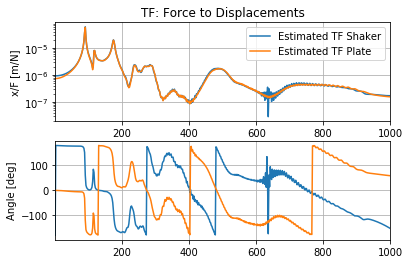

In [66]:
# TF Force/Displacements Plot
plt.figure()

plt.subplot(211)
plt.semilogy(frequencies_measurement, np.abs(estimated_tf_force_PC), label='Estimated TF Shaker')
plt.semilogy(frequencies_measurement, np.abs(estimated_tf_force_PC_plate), label='Estimated TF Plate')
plt.ylabel('x/F [m/N]')
plt.xlabel('Frequency [Hz]')
plt.xlim(1,1000)
plt.title('TF: Force to Displacements')
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.ylabel('Angle [deg]')
take = plt.plot(frequencies_measurement, np.angle(estimated_tf_force_PC, deg=True))
take = plt.plot(frequencies_measurement, np.angle(estimated_tf_force_PC_plate, deg=True))
plt.xlim(1,1000)
plt.grid(True)
plt.show()

In [67]:
delta_frf_plate_shaker = estimated_tf_force_PC_plate - estimated_tf_force_PC

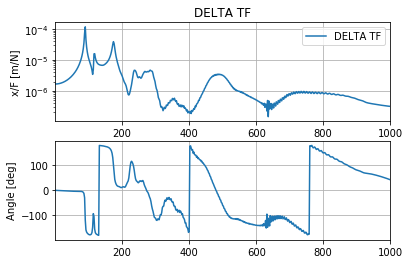

In [68]:
# DELTA TF PLOT
plt.figure()
plt.subplot(211)
plt.semilogy(frequencies_measurement, np.abs(delta_frf_plate_shaker), label='DELTA TF')

plt.ylabel('x/F [m/N]')
plt.xlabel('Frequency [Hz]')
plt.xlim(1,1000)
plt.title('DELTA TF')
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.ylabel('Angle [deg]')
take = plt.plot(frequencies_measurement, np.angle(delta_frf_plate_shaker, deg=True))
plt.xlim(1,1000)
plt.grid(True)
plt.show()

* Plot the transfer function(s) in the Nyquist plane. Use different colors to distinguish the frequency ranges around the resonance peaks.

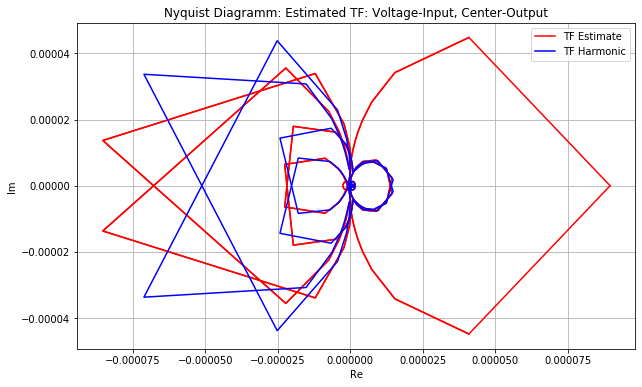

In [69]:
#Nyquist plot Voltage
plt.figure(figsize=(10, 6))
plt.plot(estimated_tf_voltage_PC_2_sided.real,estimated_tf_voltage_PC_2_sided.imag, "r",label='TF Estimate')
plt.plot(estimated_tf_voltage_PC_2_sided.real,-estimated_tf_voltage_PC_2_sided.imag, "r")
plt.plot(harmonic_voltage[Iz[NC]].real,harmonic_voltage[Iz[NC]].imag, "b",label='TF Harmonic')
plt.plot(harmonic_voltage[Iz[NC]].real,-harmonic_voltage[Iz[NC]].imag, "b")
plt.title('Nyquist Diagramm: Estimated TF: Voltage-Input, Center-Output')
plt.ylabel('Im')
plt.xlabel('Re')
plt.grid(True)
plt.legend()
plt.show()

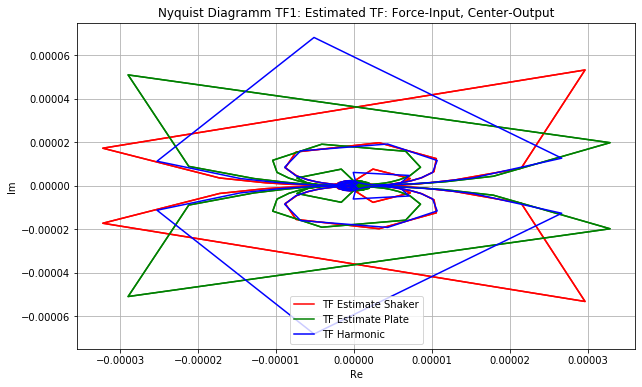

In [70]:
#Nyquist plot TF 3
plt.figure(figsize=(10, 6))
plt.plot(estimated_tf_force_PC_2_sided.real,estimated_tf_force_PC_2_sided.imag, "r", label = 'TF Estimate Shaker')
plt.plot(estimated_tf_force_PC_2_sided.real,-estimated_tf_force_PC_2_sided.imag, "r")
plt.plot(estimated_tf_force_PC_plate_2_sided.real,estimated_tf_force_PC_plate_2_sided.imag, "g", label = 'TF Estimate Plate')
plt.plot(estimated_tf_force_PC_plate_2_sided.real,-estimated_tf_force_PC_plate_2_sided.imag, "g")
plt.plot(harmonic_force_v2.real,harmonic_force_v2.imag, "b", label = 'TF Harmonic')
plt.plot(harmonic_force_v2.real,-harmonic_force_v2.imag, "b")
plt.title('Nyquist Diagramm TF1: Estimated TF: Force-Input, Center-Output')
plt.ylabel('Im')
plt.xlabel('Re')
plt.grid(True)
plt.legend()
plt.show()